### Author : Nasrin Alipour(nasrin.alipour78@gmail.com)
### Date : 5 sep 2022
### reference : keras.io

# in this project we will create a simple OCR model using Keras Functional API
### (we will use RNN and CNN layers in models and layers which we create)

In [7]:
import cv2 as cv
import tensorflow as tf
import tensorflow.keras as tfk
from tensorflow.keras import utils, layers, losses, optimizers, models, Sequential, Model
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
import os
import pandas as pd
from pathlib import Path
from collections import Counter
from io import BytesIO
from zipfile import ZipFile
from urllib.request import urlopen
#from data_utilsss import *
#from utilsss import *

In [2]:
'''
# the next cell will download the data directly(it does not need mount drive for the corrector)
drive.mount('/content/drive')
# path to data directory
data = Path("/content/drive/MyDrive/samples/")
'''

Mounted at /content/drive


In [8]:
resp = urlopen("https://github.com/AakashKumarNain/CaptchaCracker/raw/master/captcha_images_v2.zip")
zipfile = ZipFile(BytesIO(resp.read()))

##Utils

In [9]:
#@title Data Utils { display-mode: "form" }

def split_data(images, labels, train_size=0.9, shuffle=True):
    '''
       Description: split data to x_train, y_train, x_valid, y_valid
       *Args: 
       images: images as a array
       labels: labels as a array

       *Returns: 
       x_train: images using in training
       x_valid: images using in validation
       y_train: labels of training images
       y_valid: labels of validation images

    '''
    # 1. Get the total size of the dataset
    size = len(images)
    # 2. Make an indices array and shuffle it, if required
    indices = np.arange(size)
    if shuffle:
        np.random.shuffle(indices)
    # 3. Get the size of training samples
    train_samples = int(size * train_size)
    # 4. Split data into training and validation sets
    x_train, y_train = images[indices[:train_samples]], labels[indices[:train_samples]]
    x_valid, y_valid = images[indices[train_samples:]], labels[indices[train_samples:]]
    return x_train, x_valid, y_train, y_valid


def preprocess(img_path, label):
    '''
       Description: is preprocessing function which will be used in creating dataset.
                     it contains of reading image, convert to grayscale image float32, resize it 
                     to desired size and transpose(because we want the time-dimension to correspond to the width of the image) 
       *Args: 
       img_path: path of image to read it
       label: labels

       *Returns:
       {"image": img, "label": label}: a dict as our model is expecting two inputs


    '''
    # Read image
    img = tf.io.read_file(img_path)
    # Decode and convert to grayscale
    img = tf.io.decode_png(img, channels=1)
    # Convert to float32 in [0, 1] range
    img = tf.image.convert_image_dtype(img, tf.float32)
    # Resize to the desired size
    img = tf.image.resize(img, [50, 200])
    # Transpose the image because we want the time-dimension to correspond to the width of the image.
    img = tf.transpose(img, perm=[1, 0, 2])
    # Map the characters in label to numbers
    label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))
    # Return a dict as our model is expecting two inputs
    return {"image": img, "label": label}


def create_dataset(x_data, y_data, batch_size):
    '''
      Description: is a utility function to create a dataset(As tensorflow.python.data.ops.dataset_ops.PrefetchDataset Class)
                    which will be prepared for training step(it contains preprocess(mapped by preprocess function), batch, prefetch)
      *Args:
      x_data: CAPTCHA images (for training and validation step)
      y_data: text of correspondent CAPTCHA images
      batch_size: batch size

      *Returns:
      dataset: As tensorflow.python.data.ops.dataset_ops.PrefetchDataset Class

    '''
    dataset = tf.data.Dataset.from_tensor_slices((x_data, y_data))
    dataset = (dataset.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE).batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE))
    return dataset 


def decode_batch_predictions(pred):
    '''
        Description: is a utility function to decode the output of the inference network
        *Args:
        pred: output of inference network(prediction)

        *Returns:
        output_text: List of text: Iterate over the results(of ctc_decode) and get back the text and append them

    '''
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    results = tfk.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][:, :max_length]
    '''
        (tfk.backend.ctc_decode)
        *Args:
        y_pred: tensor (samples, time_steps, num_categories) containing the prediction, or output of the softmax.
        input_length: tensor (samples, ) containing the sequence length for each batch item in y_pred.
        greedy: perform much faster best-path search if true. This does not use a dictionary.
        beam_width: if greedy is false: a beam search decoder will be used with a beam of this width.
        top_paths: if greedy is false, how many of the most probable paths will be returned.


        *Returns:
        Tuple: List: if greedy is true(like here), returns a list of one element that contains the decoded sequence.
        Important: blank labels are returned as -1.
        Tensor (top_paths, ) that contains the log probability of each decoded sequence.
    '''
    # Iterate over the results and get back the text
    output_text = []
    for res in results:
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
    return output_text


In [10]:
# Get list of all the images
images = zipfile.namelist()[1:]
labels = [img.split(os.path.sep)[-1].split(".png")[0] for img in images]
characters = sorted(list(set(char for label in labels for char in label)))

# Mapping chars to ints(layers.StringLookup is a preprocessing layer which maps string features to integer indices.)
char_to_num = layers.StringLookup(vocabulary=list(characters), mask_token=None)
# Mapping ints back to original chars
num_to_char = layers.StringLookup(vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True)



In [11]:
# Batch size for training and validation
batch_size = 16
downsample_factor = 4

# Maximum length of any captcha in the dataset
max_length = max([len(label) for label in labels])

# Splitting data into training and validation sets
x_train, x_valid, y_train, y_valid = split_data(np.array(images), np.array(labels))

## Create dataset

In [12]:
# Create train and validation dataset
train_dataset = create_dataset(x_train, y_train, batch_size)
validation_dataset = create_dataset(x_valid, y_valid, batch_size)

## Create model

In [13]:
class CTCLayer(layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = tfk.backend.ctc_batch_cost
        # returns tensor with shape (samples,1) containing the CTC loss of each element

    def call(self, y_true, y_pred):
        # Compute the training-time loss value and add it to the layer using self.add_loss()
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        # change dtype to int64
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        # At test time, just return the computed predictions
        return y_pred

class ocr_model(layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)

        self.cnn_block1 = Sequential([
            layers.Conv2D(32, (3, 3), activation="relu", kernel_initializer="he_normal", padding="same", name="Conv1"),
            layers.MaxPooling2D((2, 2), name="pool1")
        ])

        self.cnn_block2 = Sequential([
            layers.Conv2D(64, (3, 3), activation="relu", kernel_initializer="he_normal", padding="same", name="Conv2"),
            layers.MaxPooling2D((2, 2), name="pool2")
        ])

        self.dense_block1 = Sequential([
            layers.Reshape(target_shape=((200// 4), (50 // 4) * 64), name="reshape"),
            layers.Dense(64, activation="relu", name="dense1"),
            layers.Dropout(0.2)
        ])

        self.rnn_block = Sequential([
            layers.Bidirectional(layers.LSTM(128, return_sequences=True, dropout=0.25)),
            layers.Bidirectional(layers.LSTM(64, return_sequences=True, dropout=0.25))
        ])

        self.dense_block2 = layers.Dense(len(char_to_num.get_vocabulary()) + 1, activation="softmax", name="dense2")
        self.ctc_block = CTCLayer(name="ctc_loss")

    def call(self, x):
      x = self.cnn_block1(x)
      x = self.cnn_block2(x)
      x = self.dense_block1(x)
      x = self.rnn_block(x)
      x = self.dense_block2(x)
      return x

# We could create model directlu by defining "class ocr_model(Model)" and bringing below codes into it but we do NOT need CTC layer in inference steps

input_image = layers.Input(shape=(200, 50, 1), name="image", dtype="float32")
labels = layers.Input(name="label", shape=(None,), dtype="float32")
ocr_layer = ocr_model(name="ocr")(input_image)
output = CTCLayer(name="ctc_loss")(labels, ocr_layer)
model = tfk.models.Model(inputs=[input_image, labels], outputs=output, name="ocr_model_v1")
model.compile(optimizer=tfk.optimizers.Adam())


## Training

In [14]:
epochs = 50

# Add early stopping
early_stopping = tfk.callbacks.EarlyStopping(monitor="val_loss", patience=10, verbose=0, mode="auto", baseline=None, restore_best_weights=True)
# Train the model
history = model.fit(train_dataset, validation_data=validation_dataset, epochs=epochs, callbacks=[early_stopping])

Epoch 1/50
59/59 [==============================] - 21s 68ms/step - loss: 20.9584 - val_loss: 16.4343
Epoch 2/50
59/59 [==============================] - 2s 38ms/step - loss: 16.3598 - val_loss: 16.4232
Epoch 3/50
59/59 [==============================] - 2s 37ms/step - loss: 16.3437 - val_loss: 16.4379
Epoch 4/50
59/59 [==============================] - 2s 38ms/step - loss: 16.3364 - val_loss: 16.4532
Epoch 5/50
59/59 [==============================] - 2s 38ms/step - loss: 16.3314 - val_loss: 16.4520
Epoch 6/50
59/59 [==============================] - 2s 37ms/step - loss: 16.3274 - val_loss: 16.4543
Epoch 7/50
59/59 [==============================] - 2s 38ms/step - loss: 16.3143 - val_loss: 16.4491
Epoch 8/50
59/59 [==============================] - 2s 37ms/step - loss: 16.3072 - val_loss: 16.4390
Epoch 9/50
59/59 [==============================] - 2s 38ms/step - loss: 16.2947 - val_loss: 16.4241
Epoch 10/50
59/59 [==============================] - 2s 38ms/step - loss: 16.2672 - val_lo

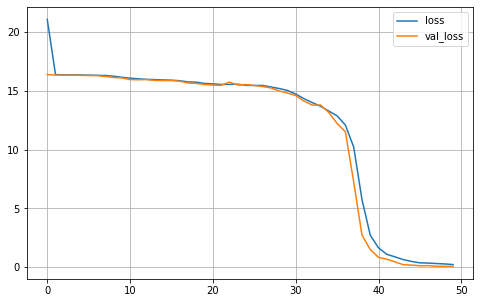

In [30]:
# Plot 
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.show()

##inference

In [9]:
# Build predictoin model
prediction_model = tfk.models.Model(model.get_layer(name="image").input, model.get_layer(name="ocr").output)

## Prediction on some validation samples

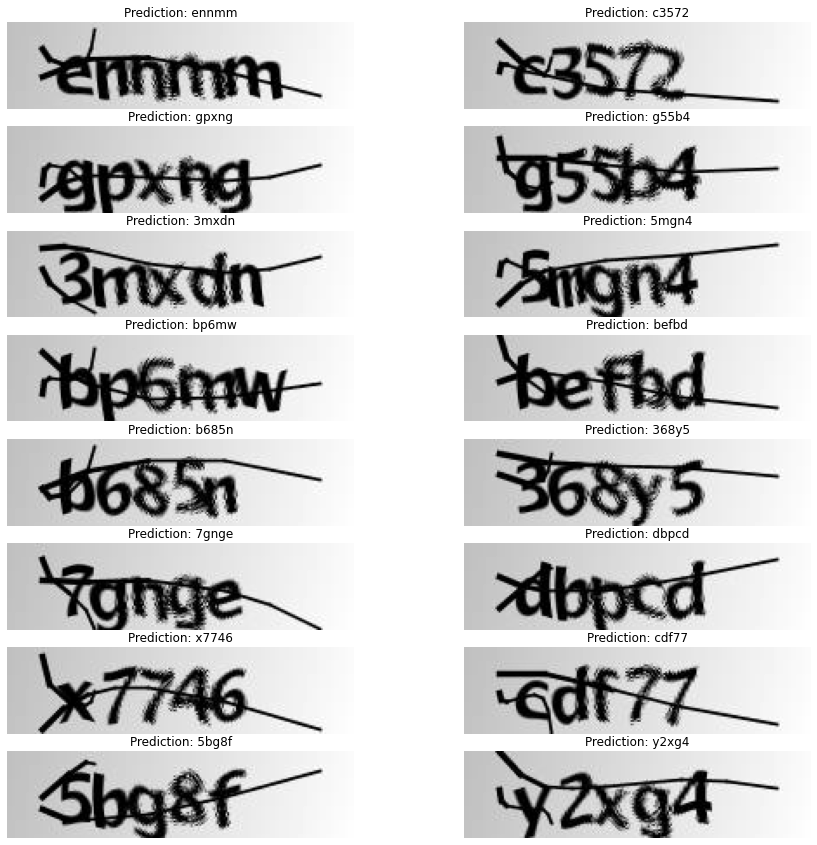

In [11]:
for batch in validation_dataset.take(1):
    batch_images = batch["image"]
    batch_labels = batch["label"]

    # predict using inference network
    preds = prediction_model.predict(batch_images)
    # decode prediction(it is descripted before)
    pred_texts = decode_batch_predictions(preds)

    orig_texts = []
    for label in batch_labels:
        # joins all strings into a single string, or joins along an axis
        label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
        orig_texts.append(label)

    _, ax = plt.subplots(8, 2, figsize=(15, 15))
    for i in range(len(pred_texts)):
        img = (batch_images[i, :, :, 0] * 255).numpy().astype(np.uint8)
        img = img.T
        title = f"Prediction: {pred_texts[i]}"
        ax[i // 2, i % 2].imshow(img, cmap="gray")
        ax[i // 2, i % 2].set_title(title)
        ax[i // 2, i % 2].axis("off")
plt.show()